# 학습 결과

user1의 scene 1~3만 사용해서 학습

scene보다 user가 많기 때문에 데이터의 양이 확연히 줄어듬에도 불구하고 성능이 괜찮음.  
적은 데이터 특화됐기 때문인지는 모르겠다.

나머지 scene에 대해서도 잘 학습을 하면서 user에 대해서도 특화된다면 성능을 상당히 끌어올릴 수 있을 것으로 기대됨.  
--> curriculum learning

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = '1122-Scene3-CLSTM2-win60'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene3_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene3_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 60

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18664, 18178)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([60, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([60, 6])

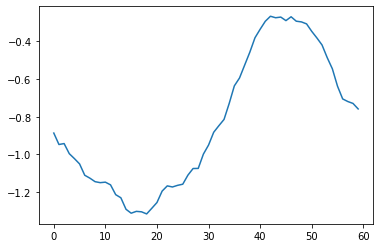

In [10]:
plt.plot(x[:, 2])

# 모델 생성

In [11]:
class CLSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=24, num_layers=8, dropout=0.0, bidirectional=False):
        super(CLSTM, self).__init__()

        self.conv_in = nn.Sequential(
            nn.Conv1d(input_size, 12, 5, padding=2),
            nn.BatchNorm1d(12),
            nn.LeakyReLU(),
            nn.Conv1d(12, 24, 5, padding=2),
            nn.BatchNorm1d(24),
        )

        self.rnn = nn.LSTM(input_size=24,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           dropout=dropout,
                           bidirectional=bidirectional)

        out_channels = 2 * hidden_size if bidirectional else hidden_size
        self.fc = nn.Linear(out_channels, 3)

    def forward(self, x):
        x = x.transpose(1, 2)  # B, 48, 6 --> B, 6, 48
        x = self.conv_in(x)  # B, 64, 48
        x = x.transpose(1, 2)  # B, 48, 64

        outs, (hiddens, cells) = self.rnn(x)
        x = outs[:, -1, ...]
        x = self.fc(x)

        return x

In [12]:
model = CLSTM(input_size=6, hidden_size=64, num_layers=8, dropout=0.2, bidirectional=True).cuda()

In [13]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [14]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [15]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [16]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [17]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :  18.964108
 - Pitch        :  10.164194
 - Roll         :   2.585906
 - RMS          :  12.511796
 - 99% Tile     :  43.600461
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :  16.006159
 - Pitch        :   9.006452
 - Roll         :   2.599421
 - RMS          :  10.709346
 - 99% Tile     :  40.584671
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :  11.911264
 - Pitch        :   8.951899
 - Roll         :   2.384290
 - RMS          :   8.712052
 - 99% Tile     :  34.291900
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.872518
 - Pitch        :   8.241949
 - Roll         :   2.374340
 - RMS          :   7.550581
 - 99% Tile     :  30.974430
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   8.122780
 - Pitch        :   7.623143
 - Roll         :   2.388016
 - RMS          :   6.577600
 - 99% Tile     :  28.605207
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   7.247237
 - Pitch        :   7.203657
 - Roll         :   2.407346
 - RMS          :   6.061090
 - 99% Tile     :  25.969343
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.246161
 - Pitch        :   7.112129
 - Roll         :   2.374032
 - RMS          :   5.634210
 - 99% Tile     :  24.297398
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.403385
 - Pitch        :   6.936771
 - Roll         :   2.374824
 - RMS          :   5.258490
 - 99% Tile     :  22.633353
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.475614
 - Pitch        :   6.928471
 - Roll         :   2.368238
 - RMS          :   4.954573
 - 99% Tile     :  22.082719
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.169696
 - Pitch        :   7.031218
 - Roll         :   2.337202
 - RMS          :   4.908731
 - 99% Tile     :  21.672473
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.717454
 - Pitch        :   6.789948
 - Roll         :   2.332738
 - RMS          :   4.667781
 - 99% Tile     :  20.933876
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.448948
 - Pitch        :   6.550673
 - Roll         :   2.354312
 - RMS          :   4.485137
 - 99% Tile     :  20.364688
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.431175
 - Pitch        :   5.928831
 - Roll         :   2.339915
 - RMS          :   4.179282
 - 99% Tile     :  20.044374
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.495384
 - Pitch        :   4.271893
 - Roll         :   2.299048
 - RMS          :   3.452168
 - 99% Tile     :  16.673965
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.202549
 - Pitch        :   3.048987
 - Roll         :   2.334249
 - RMS          :   2.555795
 - 99% Tile     :  13.377637
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.398910
 - Pitch        :   2.799642
 - Roll         :   2.293094
 - RMS          :   2.506727
 - 99% Tile     :  11.573147
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.320822
 - Pitch        :   2.096148
 - Roll         :   2.329421
 - RMS          :   2.251389
 - 99% Tile     :  10.548941
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.062597
 - Pitch        :   1.968833
 - Roll         :   2.308614
 - RMS          :   2.118200
 - 99% Tile     :  10.065959
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.611997
 - Pitch        :   2.002547
 - Roll         :   2.283495
 - RMS          :   1.985202
 - 99% Tile     :   9.693919
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.970741
 - Pitch        :   1.986272
 - Roll         :   2.226372
 - RMS          :   2.064447
 - 99% Tile     :   9.155835
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.451226
 - Pitch        :   1.695291
 - Roll         :   2.331851
 - RMS          :   1.863474
 - 99% Tile     :   8.484226
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.542923
 - Pitch        :   1.338803
 - Roll         :   2.261579
 - RMS          :   1.759521
 - 99% Tile     :   8.161620
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.652423
 - Pitch        :   1.564060
 - Roll         :   2.233517
 - RMS          :   1.840777
 - 99% Tile     :   7.895537
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.718906
 - Pitch        :   1.485839
 - Roll         :   2.262916
 - RMS          :   1.851409
 - 99% Tile     :   7.773852
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.555826
 - Pitch        :   1.372492
 - Roll         :   2.234185
 - RMS          :   1.760295
 - 99% Tile     :   7.520442
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.338979
 - Pitch        :   1.209671
 - Roll         :   2.263945
 - RMS          :   1.671488
 - 99% Tile     :   7.325925
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.341522
 - Pitch        :   1.088093
 - Roll         :   2.250071
 - RMS          :   1.637727
 - 99% Tile     :   7.071836
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.208851
 - Pitch        :   1.135573
 - Roll         :   2.246885
 - RMS          :   1.612383
 - 99% Tile     :   7.071541
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.215320
 - Pitch        :   1.088987
 - Roll         :   2.285948
 - RMS          :   1.621568
 - 99% Tile     :   6.901389
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.449259
 - Pitch        :   1.041160
 - Roll         :   2.250759
 - RMS          :   1.658341
 - 99% Tile     :   7.041455
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.454984
 - Pitch        :   1.067177
 - Roll         :   2.242002
 - RMS          :   1.661567
 - 99% Tile     :   6.947062
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.435737
 - Pitch        :   1.169090
 - Roll         :   2.258626
 - RMS          :   1.686170
 - 99% Tile     :   7.013828
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.247018
 - Pitch        :   1.221995
 - Roll         :   2.306836
 - RMS          :   1.670311
 - 99% Tile     :   7.005770
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.266129
 - Pitch        :   1.050724
 - Roll         :   2.248037
 - RMS          :   1.608392
 - 99% Tile     :   6.728228
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.967617
 - Pitch        :   0.922091
 - Roll         :   2.261565
 - RMS          :   1.516708
 - 99% Tile     :   6.693710
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.009785
 - Pitch        :   0.947934
 - Roll         :   2.258462
 - RMS          :   1.529586
 - 99% Tile     :   6.701551
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.032601
 - Pitch        :   1.021818
 - Roll         :   2.246190
 - RMS          :   1.544425
 - 99% Tile     :   6.651680
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   0.960599
 - Pitch        :   0.939921
 - Roll         :   2.256686
 - RMS          :   1.516447
 - 99% Tile     :   6.639639
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.058574
 - Pitch        :   0.934649
 - Roll         :   2.282850
 - RMS          :   1.549791
 - 99% Tile     :   6.670805
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.001922
 - Pitch        :   1.129124
 - Roll         :   2.259330
 - RMS          :   1.568794
 - 99% Tile     :   6.679882
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.995152
 - Pitch        :   0.929309
 - Roll         :   2.247788
 - RMS          :   1.517289
 - 99% Tile     :   6.631977
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.158044
 - Pitch        :   0.948210
 - Roll         :   2.249658
 - RMS          :   1.560035
 - 99% Tile     :   6.501768
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.894624
 - Pitch        :   0.860565
 - Roll         :   2.245557
 - RMS          :   1.481379
 - 99% Tile     :   6.547526
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.046192
 - Pitch        :   0.939272
 - Roll         :   2.235644
 - RMS          :   1.524779
 - 99% Tile     :   6.549231
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.137185
 - Pitch        :   0.998390
 - Roll         :   2.234282
 - RMS          :   1.557989
 - 99% Tile     :   6.512501
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.058847
 - Pitch        :   0.863221
 - Roll         :   2.241180
 - RMS          :   1.515387
 - 99% Tile     :   6.578074
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.099213
 - Pitch        :   0.960437
 - Roll         :   2.230724
 - RMS          :   1.539138
 - 99% Tile     :   6.501602
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.132224
 - Pitch        :   0.911841
 - Roll         :   2.216608
 - RMS          :   1.530439
 - 99% Tile     :   6.528896
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.980520
 - Pitch        :   0.852121
 - Roll         :   2.245132
 - RMS          :   1.497570
 - 99% Tile     :   6.510755
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.909199
 - Pitch        :   0.854210
 - Roll         :   2.245840
 - RMS          :   1.483253
 - 99% Tile     :   6.514955
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.033485
 - Pitch        :   0.844732
 - Roll         :   2.242619
 - RMS          :   1.506763
 - 99% Tile     :   6.480732
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.112586
 - Pitch        :   0.889400
 - Roll         :   2.238252
 - RMS          :   1.531737
 - 99% Tile     :   6.480289
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.858740
 - Pitch        :   0.924998
 - Roll         :   2.245410
 - RMS          :   1.487159
 - 99% Tile     :   6.558369
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.954504
 - Pitch        :   0.868612
 - Roll         :   2.243659
 - RMS          :   1.494386
 - 99% Tile     :   6.447034
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.900497
 - Pitch        :   0.925383
 - Roll         :   2.248817
 - RMS          :   1.497153
 - 99% Tile     :   6.494591
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.008475
 - Pitch        :   0.897658
 - Roll         :   2.254501
 - RMS          :   1.517189
 - 99% Tile     :   6.532297
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.181760
 - Pitch        :   0.887658
 - Roll         :   2.238381
 - RMS          :   1.548638
 - 99% Tile     :   6.483996
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 0.000125 to 6.25e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.007854
 - Pitch        :   0.910870
 - Roll         :   2.249158
 - RMS          :   1.517033
 - 99% Tile     :   6.541947
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.916035
 - Pitch        :   0.858934
 - Roll         :   2.239361
 - RMS          :   1.482298
 - 99% Tile     :   6.482621
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.910502
 - Pitch        :   0.831002
 - Roll         :   2.252763
 - RMS          :   1.482624
 - 99% Tile     :   6.491328
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.968500
 - Pitch        :   0.833130
 - Roll         :   2.253326
 - RMS          :   1.495502
 - 99% Tile     :   6.501937
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   0.984320
 - Pitch        :   0.820279
 - Roll         :   2.253856
 - RMS          :   1.496843
 - 99% Tile     :   6.484098
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

                  validation
 - Yaw          :   0.892003
 - Pitch        :   0.823393
 - Roll         :   2.254009
 - RMS          :   1.478085
 - 99% Tile     :   6.482557
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   0.977538
 - Pitch        :   0.886610
 - Roll         :   2.242068
 - RMS          :   1.502057
 - 99% Tile     :   6.451589
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.037879
 - Pitch        :   0.881882
 - Roll         :   2.240709
 - RMS          :   1.513901
 - 99% Tile     :   6.493853
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0065.npy


[0067/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.003050
 - Pitch        :   0.837438
 - Roll         :   2.248100
 - RMS          :   1.501262
 - 99% Tile     :   6.484866
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0066.npy


[0068/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   0.938007
 - Pitch        :   0.902048
 - Roll         :   2.244434
 - RMS          :   1.497890
 - 99% Tile     :   6.474052
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0067.npy


[0069/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

Decaying lr from 6.25e-05 to 3.125e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.070568
 - Pitch        :   0.833145
 - Roll         :   2.249092
 - RMS          :   1.516428
 - 99% Tile     :   6.495187
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0068.npy


[0070/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   0.988681
 - Pitch        :   0.875473
 - Roll         :   2.248556
 - RMS          :   1.505539
 - 99% Tile     :   6.522868
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0069.npy


[0071/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.035465
 - Pitch        :   0.852096
 - Roll         :   2.245065
 - RMS          :   1.509809
 - 99% Tile     :   6.479710
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0070.npy


[0072/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   0.920901
 - Pitch        :   0.896970
 - Roll         :   2.249317
 - RMS          :   1.495776
 - 99% Tile     :   6.522126
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0071.npy


[0073/0100] Train:   0%|                                                     | 0/73 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   1.004127
 - Pitch        :   0.838505
 - Roll         :   2.244886
 - RMS          :   1.500097
 - 99% Tile     :   6.472727
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0072.npy


[0073/0100] Validation: 100%|██████████████████████| 72/72 [00:02<00:00, 26.75it/s, val_loss 3.9527]

Decaying lr from 3.125e-05 to 1.5625e-05 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   0.961992
 - Pitch        :   0.857509
 - Roll         :   2.244754
 - RMS          :   1.494397
 - 99% Tile     :   6.490741
Save output signals into checkpoint/1122-Scene3-CLSTM2-win60/sample/0073.npy
